<hr style="border-width:4px; border-color:coral; border-style:solid"/></br>

## Check accuracy on multiple processors

<hr style="border-width:4px; border-color:coral; border-style:solid"/>

This notebook shows you how to check accuracy from your MPI runs.  In this example, we run the C program `integral.c` on 1, 2, 4, 8 processors and create files `integral_01.out`, `integral_02.out`, `integral_02.out` and so on.  The idea is to ensure that we get the same answer regardless of the number of processors.   A secondary goal is to test the accuracy of our scheme by looking at how the error decreases with increasing number of points used to compute the integral.

* [Problem specification](#problem)
* [Code integral.c](#integral)
* [Run code](#run)
* [Read the code into a MultiIndex](#multiIndex)


This code also demonstrates how use the Pandas DataFrame and a MultiIndex to store the data for all the runs.  This will allow us to easily compare errors across different processor counts.

In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<a id="problem"></a>

## Problem specification

We specify the range of processors over which to run the problem and the range of N values (specified as powers of 2).  

In [2]:
# Range of processor counts
procs = [1,2,4,8]   # set to 1,2,4, and 8

# Range of N values
Nvec = 2**array(range(10,20))

# Name of executable
exec_file = 'integral'

<a id="integral"></a>

## File `integral.c`



In [3]:
%%file integral.c

#include <stdio.h>   /* Needed for printf */
#include <stdlib.h>  /* Needed for atoi */

#include <math.h>  /* Needed for math functions exp and pow */
#include <mpi.h>   /* Needed for MPI library routines */

double integrand(double x)
{
    /* Function to integrate */
    return pow((x-1),2)*exp(-pow(x,2));
}

int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    /* -------------------- User input ------------------------ */
    int N = atoi(argv[1]);    

    /* ------------------ Processor info ----------------------- */
    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    /* ---------------- Numerical parameters --------------------*/
    int Nlocal = N/nprocs;
    double a = 0;
    double b = 1;
    double w = (b-a)/nprocs;
    double h = (b-a)/N;

    /* ----------------- Compute integral ----------------------*/

    double integral = 0;
    for(int i = 0; i < Nlocal; i++)
    {
        double x = a + w*rank + h*i;
        integral += integrand(x)*h;
    }

    double total_sum;
    int root = 0;
    MPI_Reduce(&integral,&total_sum,1,MPI_DOUBLE,MPI_SUM,root,MPI_COMM_WORLD);

    /* --------------------- Output error ----------------------*/

    if (rank == 0)
    {        
        /* integral I(0,1) */
        double error = fabs(total_sum - 0.3041759198043616);

        char fname[16];
        sprintf(fname,"integral_%02d.out",nprocs);
        FILE *fout = fopen(fname,"a");        
        fwrite(&N,1,sizeof(int),fout);
        fwrite(&error,1,sizeof(double),fout);
        fclose(fout);
    }

    MPI_Finalize();
    return 0;
}

Overwriting integral.c


## Compile and test the code

In [4]:
%%bash 

rm -rf integral integral.o integral_04.out

mpicc -o integral integral.c

mpirun -n 1 integral 1024

And check the output to see that we get something reasonable.  We first create a data type, read in the binary data, and then print it out. 

In [5]:
# Create a data type corresponding to what we wrote out in 'integral.c'
dt = dtype([('N','int32'), ('Error','d')])

nprocs = 1
fname = 'integral_{:02d}.out'.format(nprocs)

# Open and read data 
fout = open(fname,"rb")
data = fromfile(fout,dtype=dt)
fout.close()

# Assign N and error, and print out error
N = data[0][0]
err = data[0][1]

print("N = {:d}\nError = {:.8e}".format(N,err))

N = 1024
Error = 4.88440196e-04


<a id="run"></a>

## Run code over range of P and N

We run all jobs above and collect the data in a Pandas data frame.   The errors should be identical (up to rounding error) for the same N, regardless of number of processors.  

In [6]:
import pandas

idx = pandas.IndexSlice

index = pandas.MultiIndex.from_product([procs,Nvec],names=['Proc','N'])
cols = ['Error']

dt = dtype([('Error','d')])
df_error = pandas.DataFrame(index=index,columns = cols,dtype='d').sort_index()
df_error

Error
Proc N            
1    1024      NaN
     2048      NaN
     4096      NaN
     8192      NaN
     16384     NaN
     32768     NaN
     65536     NaN
     131072    NaN
     262144    NaN
     524288    NaN
2    1024      NaN
     2048      NaN
     4096      NaN
     8192      NaN
     16384     NaN
     32768     NaN
     65536     NaN
     131072    NaN
     262144    NaN
     524288    NaN
4    1024      NaN
     2048      NaN
     4096      NaN
     8192      NaN
     16384     NaN
     32768     NaN
     65536     NaN
     131072    NaN
     262144    NaN
     524288    NaN
8    1024      NaN
     2048      NaN
     4096      NaN
     8192      NaN
     16384     NaN
     32768     NaN
     65536     NaN
     131072    NaN
     262144    NaN
     524288    NaN

In [7]:
import subprocess
import shlex
import os

# Output file
filename = '{fexec:s}_{np:02}.out'.format

# mpirun command
shell_cmd = 'mpirun -n {np:d} {fexec:s} {N:d}'.format

dt = dtype([('N','int32'), ('Error','d')])      

for np in procs:
    output_fname = filename(fexec=exec_file,np=np)    
    try:
        os.remove(output_fname)
    except OSError as error: 
        #print(error)
        pass
    tvec = []
    for N in Nvec:
        cmd = shell_cmd(np=np,fexec=exec_file,N=N)
        arg_list = shlex.split(cmd) 
        output = subprocess.run(arg_list)
        
    fout = open(output_fname,"rb")
    data = fromfile(fout,dtype=dt)
    fout.close()

    df = pandas.DataFrame(data)
    df_error.loc[(np,),:] = df[cols].values
    

<a id="multiIndex"></a>

## Reading the data into Pandas 'MultiIndex'

The Pandas 'MultiIndex' is a nice feature to allow us to store multi-dimensional data.  Below, we store data for each tuple (P,N), where P is the processor count, and N is the dimension of the problem.   The data that we will store is the error.  

In [8]:
df = df_error.unstack(1).copy()
df.style.format('{:.6e}'.format)

<IPython.core.display.Javascript object>


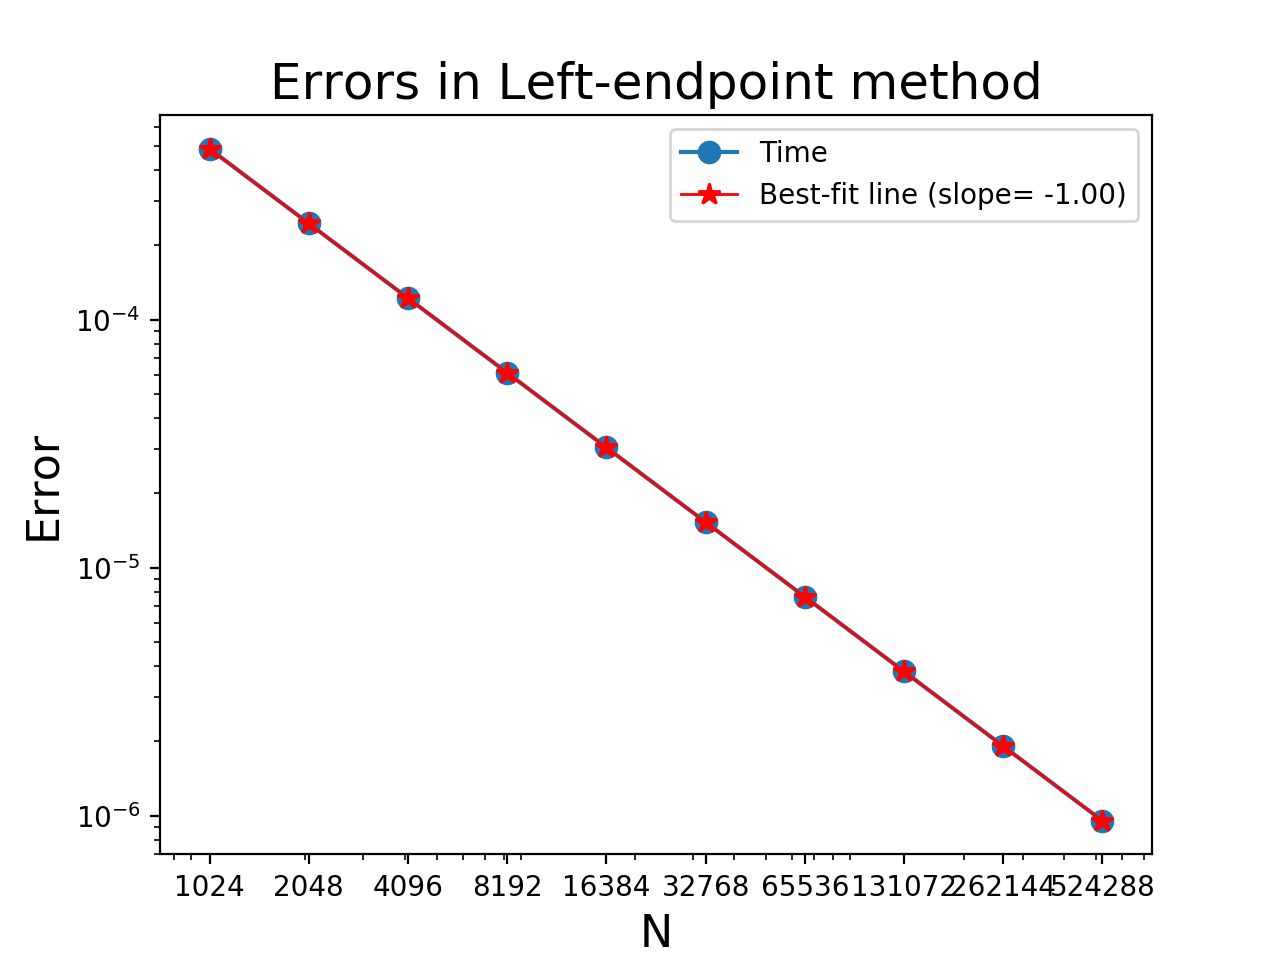

In [9]:
figure(1)
clf()

# plot results from processor 1 (since they are all the same)
df_plot = df_error.loc[idx[1],:]

loglog(Nvec,df_plot.values,'.-',markersize=15,label='Time')

# Add slope to get best fit line
nv = array(Nvec).astype('d')
c = polyfit(log(nv),log(df_plot.values),1)
loglog(nv,exp(polyval(c,log(nv))),'r*-', markersize=8,\
         label='Best-fit line (slope={:6.2f})'.format(c[0][0]),linewidth=1)

# Add title, xlabel, ylabel, xticks and a legend
def fix_xticks(Nvec):
    p0 = log2(Nvec[0])
    p1 = log2(Nvec[-1])
    xlim([2**(p0-0.5), 2**(p1+0.5)])
    
    # Make nice tick marks
    pstr = (['{:d}'.format(int(N)) for N in Nvec])
    xticks(Nvec,pstr)

fix_xticks(Nvec)  # Need numpy array, not a Pandas 'Series'
xlabel("N",fontsize=16)
ylabel("Error",fontsize=16)
title("Errors in Left-endpoint method",fontsize=18)
legend()